# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
import sys

sys.path.append("scripts")
from expressions_EDA import renormalize_tpm
from expressions_PCA import compute_pca_all, compute_pca_by_dataset, plot_pca

# Data load and normalisation

In [2]:
expressions = pd.read_csv("../data/expression_all.csv", index_col=0)
filtered_ann = pd.read_csv("../data/annotations_filtred.csv", index_col="Sample")

In [3]:
with open("../data/genes_v2.txt", "r") as f:
    genes_in_expression = [line.rstrip("\n") for line in f]

existing_genes = set(genes_in_expression) & set(expressions.index)

print(len(existing_genes))

18792


In [4]:
normalized_expressions = renormalize_tpm(expressions, existing_genes)
log_normalized_expressions = np.log2(normalized_expressions + 1)

In [5]:
expr = log_normalized_expressions
ann = filtered_ann

common_samples = list(set(expr.columns) & set(ann.index))

expr_filtered = expr[common_samples]
datasets = ann.loc[common_samples, ["Dataset", "Diagnosis", "Sample_type"]]

# PCA distributions of selected datasets for outlier filtering

## All datasets PCA 

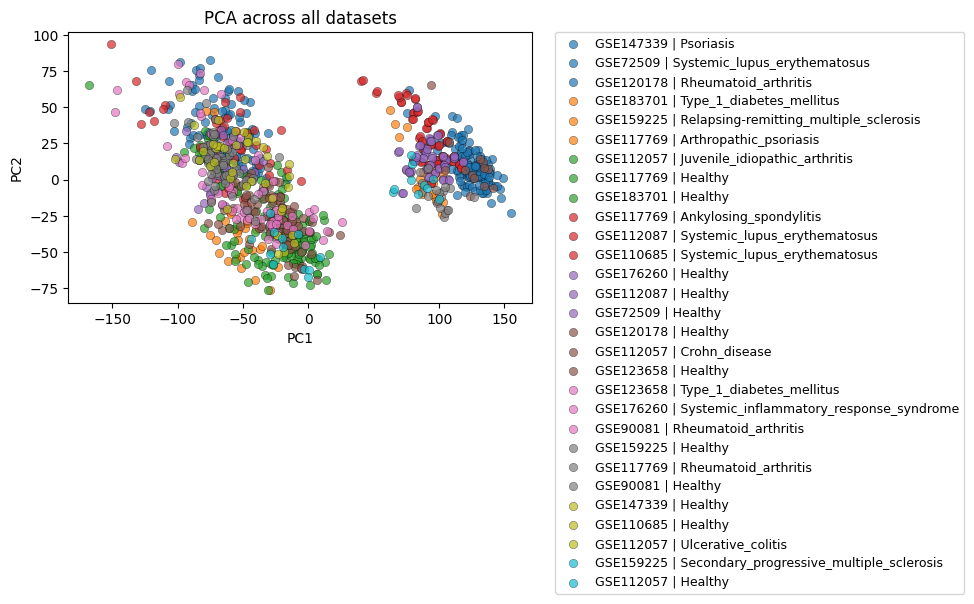

In [6]:
pca_all = compute_pca_all(expr_filtered, ann)
plot_pca(pca_all, title="PCA across all datasets", per_dataset=False, savepath="../images/pca_all_datasets.png")


## Each datasets PCA 

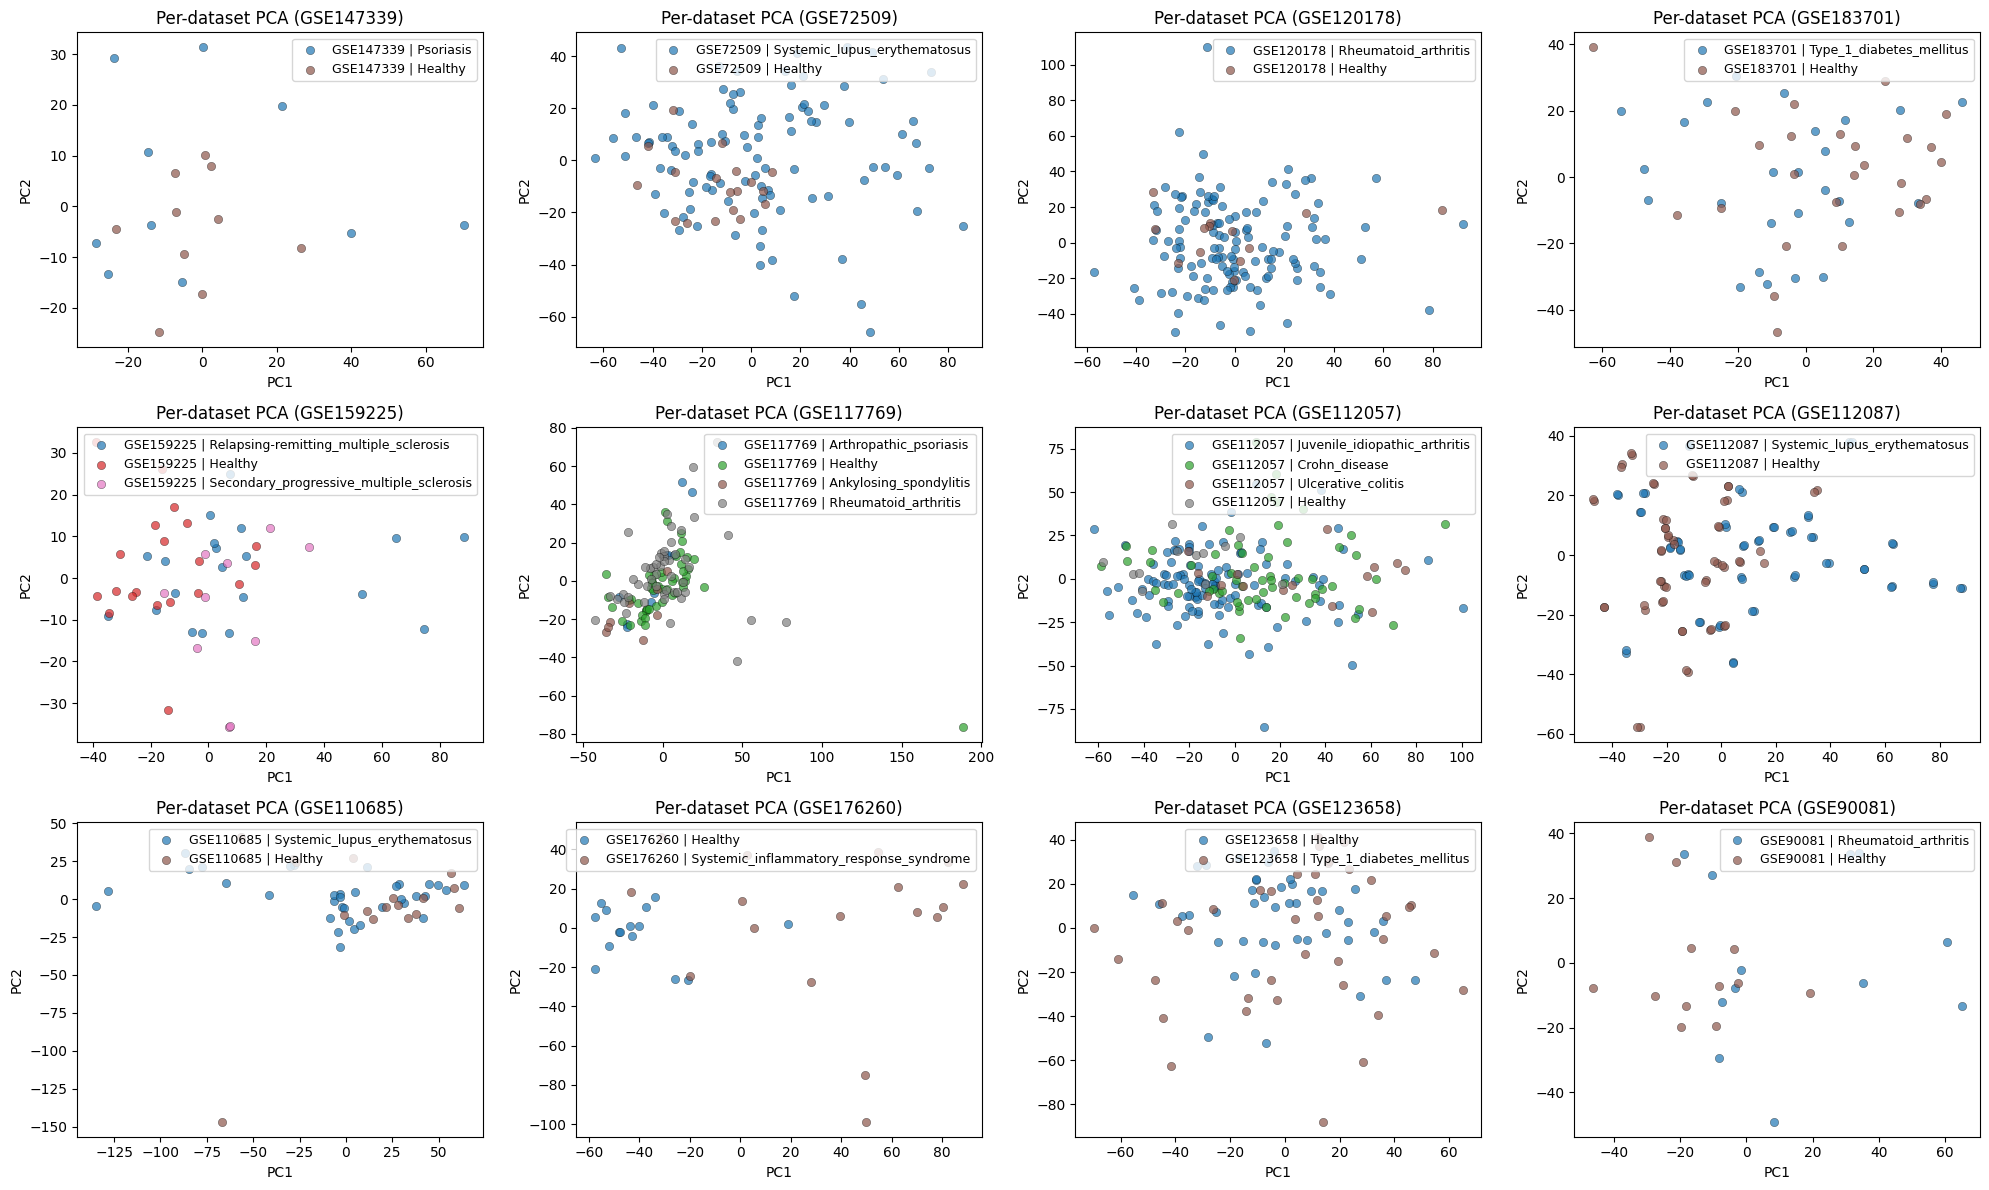

In [7]:
pca_multi = compute_pca_by_dataset(expr_filtered, ann, sample_type="Whole_blood")
plot_pca(pca_multi, title="Per-dataset PCA", per_dataset=True)

In [8]:
pca_multi.query("Dataset == 'GSE110685' and PC2 < -125")

,PC1,PC2,Dataset,Diagnosis,Sample_type,Sample
Sample,,,,,,
SRX3703133,-66.952831,-147.178382,GSE110685,Healthy,Whole_blood,SRX3703133


In [9]:
pca_multi.query("`Dataset` == 'GSE117769' & `PC2` < -60")

,PC1,PC2,Dataset,Diagnosis,Sample_type,Sample
Sample,,,,,,
SRX4475059,188.878886,-76.588704,GSE117769,Healthy,Whole_blood,SRX4475059


In [10]:
samples_to_remove = ["SRX3703133", "SRX4475059"]
samples_to_remove_expr = [
    sample for sample in samples_to_remove if sample in expr_filtered.columns
]
expr = expr_filtered.drop(columns=samples_to_remove_expr)

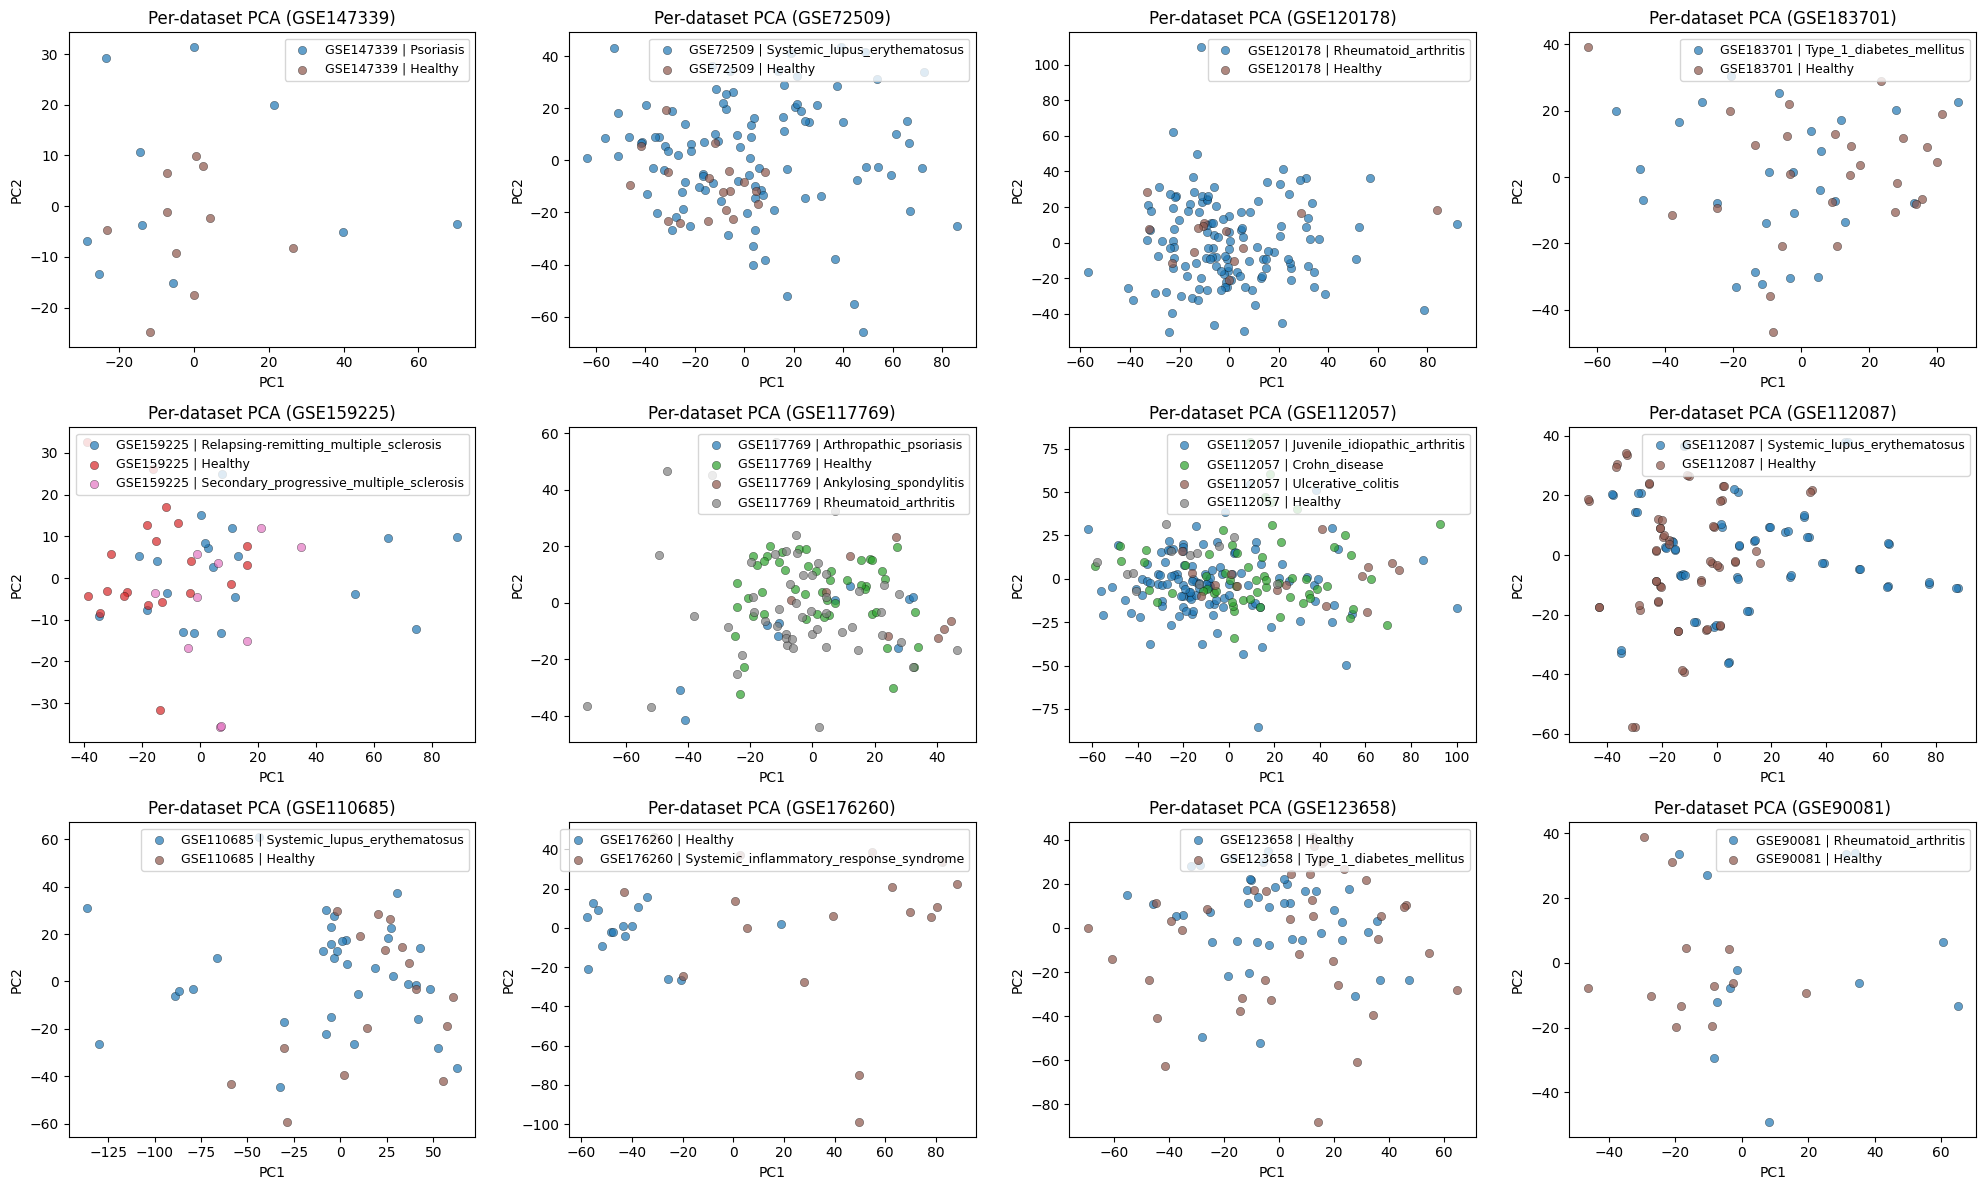

In [11]:
pca_multi = compute_pca_by_dataset(expr, ann, sample_type="Whole_blood")
plot_pca(pca_multi, title="Per-dataset PCA", per_dataset=True, savepath="../images/pca_per_datasets.png")

# Checking housekeeping gene expression

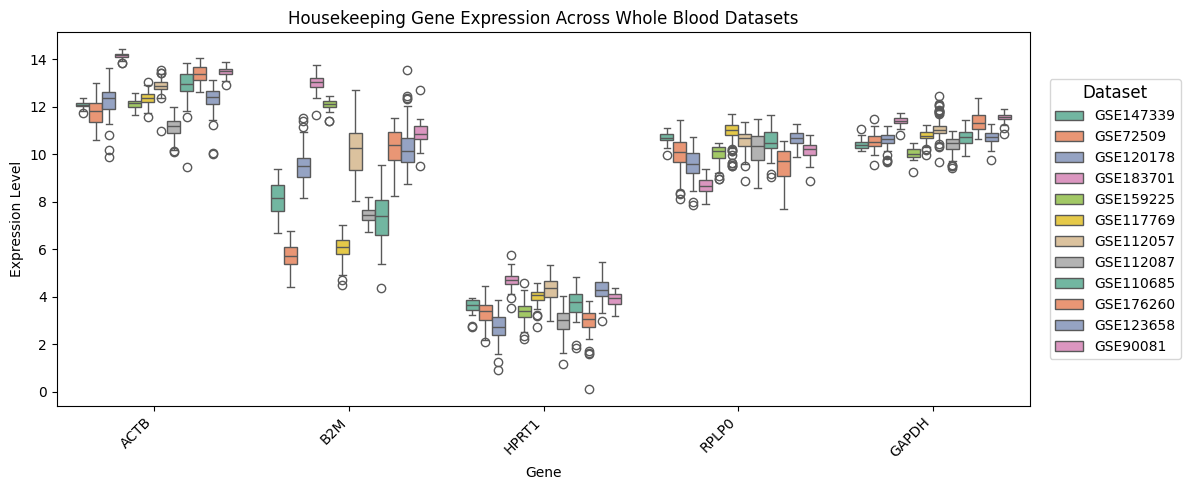

In [12]:
housekeeping_genes = ["GAPDH", "ACTB", "B2M", "HPRT1", "RPLP0"]
existing_housekeeping = list(set(housekeeping_genes) & set(expr.index))

expr_housekeeping = expr.loc[existing_housekeeping].T
expr_housekeeping = expr_housekeeping.join(ann[["Dataset"]])
expr_melted = expr_housekeeping.melt(
    id_vars=["Dataset"], var_name="Gene", value_name="Expression"
)


plt.figure(figsize=(12, 5))
sns.boxplot(
    data=expr_melted,
    x="Gene",
    y="Expression",
    hue="Dataset",
    palette="Set2",
    dodge=True,
)

plt.xticks(rotation=45, ha="right")
plt.title("Housekeeping Gene Expression Across Whole Blood Datasets")
plt.xlabel("Gene")
plt.ylabel("Expression Level")
plt.legend(
    title="Dataset",
    fontsize=10,
    title_fontsize=12,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    borderaxespad=0,
)
plt.tight_layout()
plt.show()

# Saving the filtered expression matrix and annotations

In [13]:
ann_filtered = ann.loc[expr.columns.intersection(ann.index)]
expr_filtered = expr[ann_filtered.index]

ann_filtered.to_csv("../data/annotations_whole_blood.csv")
expr_filtered.to_csv("../data/expression_whole_blood_all_genes.csv")